<a href="https://colab.research.google.com/github/mhussainahmad/face_detection/blob/main/siamese_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Tensorflow and depending libraries

In [11]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing Standard Dependencies

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

Importing Tensorflow Dependencies

In [13]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Input, Flatten
import tensorflow as tf

Setting GPU Growth

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Creating Folder Structures

In [5]:
POS_PATH = os.path.join("data", 'positive')
NEG_PATH = os.path.join("data", 'negative')
ANC_PATH = os.path.join("data", 'anchor')

In [6]:
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [7]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2022-08-07 22:18:43--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  11.8MB/s    in 16s     

2022-08-07 22:19:01 (10.5 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [8]:
## Uncompressing the tar file
!tar -xf lfw.tgz

 Collecting Positives and Anchor Classes

In [9]:
for directory in os.listdir('lfw'):
    for files in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, files)
        NEW_PATH = os.path.join(NEG_PATH, files)
        os.replace(EX_PATH, NEW_PATH)

## Load and preprocess the images

In [17]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [18]:
dir_test = anchor.as_numpy_iterator()

In [19]:
dir_test.next()

b'data/anchor/7da53628-117d-11ed-8164-6c02e06ff1a3.jpg'

In [20]:
## Preprocessing the images
def preprocess(file_path):
    # Reading image from the file path
    byte_img = tf.io.read_file(file_path)
    # Loading the image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing the image - Resizing to (100,100,3)
    img = tf.image.resize(img, (100,100))
    # Scaling image to be between 0 and 1
    img = img/255.0
    # Returning the image
    return img

In [21]:
img = preprocess('data/anchor/d788a134-117d-11ed-b7a9-6c02e06ff1a3.jpg')

In [22]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, positive) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
samples = data.as_numpy_iterator()

In [24]:
example = samples.next()

In [25]:
example

(b'data/anchor/24630122-117e-11ed-aa19-6c02e06ff1a3.jpg',
 b'data/positive/6a85be6f-117f-11ed-8b9c-6c02e06ff1a3.jpg',
 1.0)

## Build Train and Test Partitions

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return preprocess(input_img), preprocess(validation_img), label

In [27]:
res = preprocess_twin(*example)

In [28]:
res[2]

1.0

In [29]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
# Caching images to memory
data = data.cache()
# Shuffling the data
data = data.shuffle(buffer_size=1024)

In [30]:
# Training Partition
# Grabbing certain percentage of the data for training
train_data = data.take(round(len(data)*.7))
# Creating batches of 16 images
train_data = train_data.batch(16)
# Preprocessing next set of images
train_data = train_data.prefetch(0)

In [31]:
# Validation Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(0)

# Model Engineering

## Embedding Layer

In [32]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #Second block
    c2 = Conv2D(128,(7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding="same")(c2)

    # Third block
    c3 = Conv2D(128,(4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding="same")(c3)

    # Fourth block
    c4 = Conv2D(256,(4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp] , outputs=[d1], name='embedding')

In [33]:
embedding = make_embedding()

In [34]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

## Build Distance Layer

In [35]:
# Siamese L1 Distance class
class L1Dist(Layer):
    # Init method - inheritance from Layer class
    def __init__(self, **kwargs):
        super().__init__()

    # Similarity Calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [36]:
l1 = L1Dist()

Make Siamese Model

In [37]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img',shape=(100,100,3))
    # Validation image input in the network
    validation_image = Input(name='validation_img',shape=(100,100,3))

    # combine siamese distance layer with the embedding layer
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='siameseNetwork')

In [38]:
siamese_model = make_siamese_model()

In [39]:
siamese_model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

Setup loss and optimizer

In [40]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [41]:
optimizer = tf.keras.optimizers.Adam(1e-4) # 0.0001

Establish Checkpoints

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)

## Build Train Step Function

In [43]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get the labels
        y = batch[2]
        # Forward pass
        y_pred = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, y_pred)

        # Calculating gradients
        grad = tape.gradient(loss, siamese_model.trainable_variables)

        # Calculating updated weights and apply to siamese model
        optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
        return loss

Build training loop

In [44]:
def train(t_data, t_epoch):
    # Loop through epochs
    for epoch in range(1, t_epoch+1):
        print('\n EPOCH {}/{}'.format(epoch, t_epoch))
        progbar = tf.keras.utils.Progbar(len(t_data))

        # Loop through each batch
        for idx, batch in enumerate(t_data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

Train the model

In [45]:
t_epoch = 50

In [46]:
train(train_data, t_epoch)


 EPOCH 1/50
27/27 [==============================] - 22s 197ms/step

 EPOCH 2/50
27/27 [==============================] - 5s 186ms/step

 EPOCH 3/50
27/27 [==============================] - 5s 187ms/step

 EPOCH 4/50
27/27 [==============================] - 5s 187ms/step

 EPOCH 5/50
27/27 [==============================] - 5s 188ms/step

 EPOCH 6/50
27/27 [==============================] - 5s 189ms/step

 EPOCH 7/50
27/27 [==============================] - 5s 190ms/step

 EPOCH 8/50
27/27 [==============================] - 5s 191ms/step

 EPOCH 9/50
27/27 [==============================] - 5s 192ms/step

 EPOCH 10/50
27/27 [==============================] - 5s 192ms/step

 EPOCH 11/50
27/27 [==============================] - 5s 193ms/step

 EPOCH 12/50
27/27 [==============================] - 5s 195ms/step

 EPOCH 13/50
27/27 [==============================] - 5s 195ms/step

 EPOCH 14/50
27/27 [==============================] - 5s 197ms/step

 EPOCH 15/50
27/27 [=====================

## Evaluating Model

In [47]:
# Importing metrics
from tensorflow.python.keras.metrics import Precision, Recall

In [48]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [49]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[3.1117170e-07],
       [6.0848965e-10],
       [8.7120952e-07],
       [9.9999988e-01],
       [2.7927316e-10],
       [1.0000000e+00],
       [4.3116003e-08],
       [1.0000000e+00],
       [5.7885563e-10],
       [9.9105013e-10],
       [1.8000793e-09],
       [4.9040894e-10],
       [9.9999893e-01],
       [2.7516389e-09],
       [1.0000000e+00],
       [9.9999988e-01]], dtype=float32)

## Metrics

In [50]:
# Post processing results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]

In [51]:
# Creating a metric object
m = Recall()
# Calculating the recall value
m.update_state(y_true, y_hat)
# Return Recall result
m.result().numpy()

1.0

In [52]:
# Creating a metric object
m = Precision()
# Calculating the recall value
m.update_state(y_true, y_hat)
# Return Precision result
m.result().numpy()

1.0

## Viz result

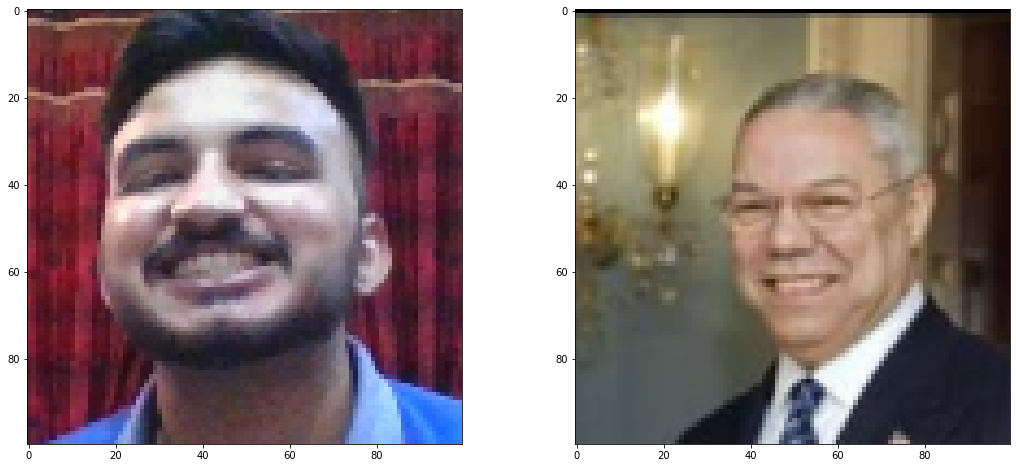

In [53]:
plt.figure(figsize = (18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])

## Save Model

In [54]:
# Saving model
siamese_model.save('siamesemodel.h5')

In [55]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist})

In [56]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[3.1117170e-07],
       [6.0848965e-10],
       [8.7120952e-07],
       [9.9999988e-01],
       [2.7927316e-10],
       [1.0000000e+00],
       [4.3116003e-08],
       [1.0000000e+00],
       [5.7885563e-10],
       [9.9105013e-10],
       [1.8000793e-09],
       [4.9040894e-10],
       [9.9999893e-01],
       [2.7516389e-09],
       [1.0000000e+00],
       [9.9999988e-01]], dtype=float32)

In [57]:
model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

## Real time tests

# Verification Function

In [83]:
def verify(model, detection_threshold, verification_threshold):
  # Build results array
  results = []
  for image in os.listdir(os.path.join('application_data', 'verification_images')):
    input_img = preprocess(os.path.join('application_data','input_image','photo.jpg'))
    validation_img = preprocess(os.path.join('application_data','verification_images',image))

    result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
    results.append(result)
  # Detection threshold: Metric above which a prediction is considered positive

  detection = np.sum(np.array(results) > detection_threshold)  
  # Verification threshold: proportion of positive predicition / total positive samples
  verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
  verified = verification > verification_threshold
  return results, verified

# OpenCV Real time Verification

In [68]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/content/application_data/input_image/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const quit = document.createElement('button');
      capture.textContent = 'Capture';
      quit.textContent = 'Quit';
      div.appendChild(capture);
      div.appendChild(quit);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to /content/application_data/input_image/photo.jpg


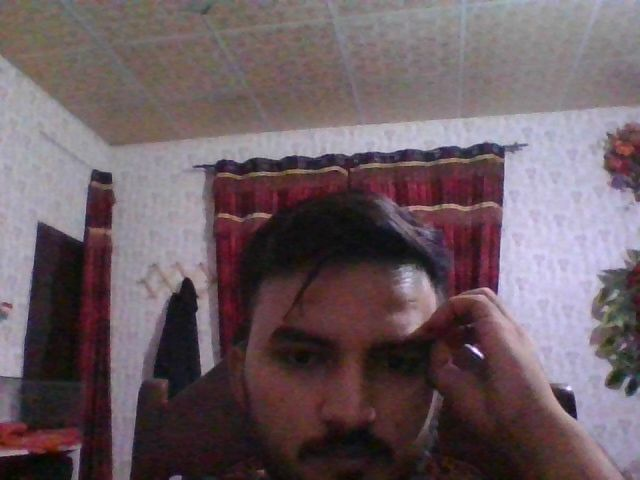

In [74]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [80]:
frame = cv2.imread(filename)

In [84]:
# Run verification
results, verified = verify(model, 0.5, 0.5)
print(verified)

True


In [87]:
np.sum(np.squeeze(results) > 0.5)

35